In [ ]:
# Import needed libraries
import pandas as pd
import numpy as np
from scipy.linalg import lstsq

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt

In [2]:
# Make it so that there is no truncation in the notebook
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)

# Disable scientific notation in display for ease of reading
pd.set_option('display.float_format', '{:.0f}'.format)


In [3]:
# Bring in each dataset

# name_df = pd.read_csv("name.basics.tsv", sep='\t')
# akas_df = pd.read_csv("title.akas.tsv", sep='\t')
basics_df = pd.read_csv("title.basics.tsv", sep='\t')
crew_df = pd.read_csv("title.crew.tsv", sep='\t') # This df has the director for each title
# principals_df = pd.read_csv("title.principals.tsv", sep='\t')
ratings_df = pd.read_csv("title.ratings.tsv", sep='\t') # This df has the rating for each movie

### This next block creates a 1-1 map for director and movie title.

In [4]:
# Remove the writers column
crew_df = crew_df.drop(columns=['writers'])

# Convert the directors string into a list of directors, then drop the old column
crew_df["directors_list"] = crew_df["directors"].apply(lambda x: x.split(",") if pd.notnull(x) and x != "\\N" else [])

crew_df = crew_df.drop(columns=["directors"])

# Remove all movies that do not have a director
crew_df = crew_df[crew_df['directors_list'].apply(lambda x: len(x) > 0)]

# create a row for each director
crew_df = crew_df.explode('directors_list')

### This next block only keeps ratings that have a number of votes over a threshold and then unions the ratings with the title + director df.

In [5]:
# This value sets the threshold for minimum number of votes to keep in the final df. 
min_votes = 1000

In [6]:
# Apply the threshold and drop the vote column.
ratings_df = ratings_df[ratings_df['numVotes'] > min_votes].drop(columns=['numVotes'])

In [7]:
# Merge the dfs on title.
directors_ratings_df = pd.merge(crew_df, ratings_df, on='tconst', how='inner') 

In [8]:
directors_ratings_df.head()

,tconst,directors_list,averageRating
0,tt0000001,nm0005690,6
1,tt0000003,nm0721526,6
2,tt0000005,nm0005690,6
3,tt0000008,nm0005690,5
4,tt0000010,nm0525910,7


### Bring in the date information and union.

In [9]:
basics_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,Short


In [10]:
basics_df.count()

tconst            12048919
titleType         12048919
primaryTitle      12048896
originalTitle     12048896
isAdult           12048919
startYear         12048919
endYear           12048919
runtimeMinutes    12048919
genres            12048309
dtype: int64

In [11]:
basics_df['titleType'].unique()

array(['short', 'movie', 'tvShort', 'tvMovie', 'tvEpisode', 'tvSeries',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame', 'tvPilot'],
      dtype=object)

In [12]:
# Only keep movies.
basics_df = basics_df[basics_df['titleType'] == 'movie']

# Only keep movies after a specific year.
min_year = 2000
basics_df = basics_df[basics_df['startYear'] != '\\N']
basics_df['startYear'] = basics_df['startYear'].astype(int)
basics_df = basics_df[basics_df['startYear'] >= min_year]

In [13]:
basics_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
11630,tt0011801,movie,Tötet nicht mehr,Tötet nicht mehr,0,2019,\N,\N,"Action,Crime"
34793,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,\N,118,"Comedy,Fantasy,Romance"
61097,tt0062336,movie,The Tango of the Widower and Its Distorting Mirror,El tango del viudo y su espejo deformante,0,2020,\N,70,Drama
67649,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,\N,122,Drama
69136,tt0070596,movie,Socialist Realism,El realismo socialista,0,2023,\N,78,"Drama,History"


In [14]:
# Only keep title and year of movie
basics_df = basics_df[['tconst', 'startYear']]

In [15]:
basics_df.head()

,tconst,startYear
11630,tt0011801,2019
34793,tt0035423,2001
61097,tt0062336,2020
67649,tt0069049,2018
69136,tt0070596,2023


In [16]:
# Merge the dfs
year_director_title_df = pd.merge(basics_df, directors_ratings_df, on='tconst', how='inner') 

In [17]:
year_director_title_df.head()

,tconst,startYear,directors_list,averageRating
0,tt0035423,2001,nm0003506,6
1,tt0069049,2018,nm0000080,7
2,tt0082328,2008,nm0596261,6
3,tt0093119,2020,nm0007013,3
4,tt0113026,2000,nm0006916,6


In [18]:
year_director_title_df.count()

tconst            35162
startYear         35162
directors_list    35162
averageRating     35162
dtype: int64

### In this block we take the ratings and create sequences of chronological ratings.

In [ ]:
sorted_df = year_director_title_df.sort_values(by=['directors_list', 'startYear'], ascending=[True, True])
ratings_sequence_df = sorted_df.groupby('directors_list')['averageRating'].apply(list).reset_index()

In [20]:
ratings_sequence_df.head()

,directors_list,averageRating
0,nm0000080,[6.7]
1,nm0000091,"[5.4, 4.1, 5.7]"
2,nm0000095,"[6.7, 6.7, 6.5, 6.3, 6.4, 7.6, 6.6, 6.6, 7.1, 7.1, 6.3, 7.6, 6.3, 7.3, 6.5, 6.6, 6.6, 6.2, 6.4, 6.1, 6.4]"
3,nm0000102,[5.3]
4,nm0000104,[5.5]


In [21]:
# Test the above code
test_df = pd.DataFrame({
    'directors_list': ['nm001', 'nm001', 'nm002', 'nm001', 'nm002', 'nm003'],
    'startYear': [2010, 2007, 2009, 2012, 2011, 2015],
    'averageRating': [9.1, 8.5, 7.8, 9.5, 8.0, 6.5]
})

In [22]:
test_sorted_df = test_df.sort_values(by=['directors_list', 'startYear'], ascending=[True, True])
test_ratings_sequence_df = test_sorted_df.groupby('directors_list')['averageRating'].apply(list).reset_index()

In [23]:
print(test_ratings_sequence_df)

  directors_list    averageRating
0          nm001  [8.5, 9.1, 9.5]
1          nm002       [7.8, 8.0]
2          nm003            [6.5]


In [24]:
# # This function taking the ratings sequences and generates new lists of length n, preparing for regression
def sliding_windows(df, n):

    new_rows = []

    for _, row in df.iterrows():
        seq = row['averageRating']
        # print(seq)
        if len(seq) < n:
            continue 
        
        # generate all sliding windows of length n
        for i in range(len(seq) - n + 1):
            window = seq[i:i+n]
            new_rows.append({'directors_list': row['directors_list'], 'rating_window': window})
    df = pd.DataFrame(new_rows)
    ratings_array = np.array(df['rating_window'].tolist(), dtype=float)
    return ratings_array
    

In [25]:
print(sliding_windows(test_ratings_sequence_df, 3))

[[8.5 9.1 9.5]]


### Now we train a linear regression model

In [26]:

two_df = sliding_windows(ratings_sequence_df, 2)
three_df = sliding_windows(ratings_sequence_df, 3)
four_df = sliding_windows(ratings_sequence_df, 4)
five_df = sliding_windows(ratings_sequence_df, 5)
dfs = [two_df, three_df, four_df, five_df]


In [27]:
for df in dfs:
    X = df[:, :-1] 
    y = df[:, -1]
    X_bias = np.hstack([np.ones((X.shape[0], 1)), X])
    coef, residuals, rank, s = lstsq(X_bias, y)
    print(f"Residual: {residuals}")

Residual: 15010.710153062022
Residual: 8257.661706155293
Residual: 5273.454612776
Residual: 3431.439659945376


### Now we train a linear regression model with sklearn

In [28]:
for i in range(2, 15):
    df = sliding_windows(ratings_sequence_df, i)
    X = df[:, :-1] 
    y = df[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)


    print(f"Test MSE for sequence length {i}: ", mse)
    print(f"Test R squaredfor sequence length {i}: ", r2)
    print(f"Mean Absolute Error {i}: ", mae)
    print()

Test MSE for sequence length 2:  0.8568522980820839
Test R squaredfor sequence length 2:  0.32448352737412933
Mean Absolute Error 2:  0.7129434553651967

Test MSE for sequence length 3:  0.8051856056312869
Test R squaredfor sequence length 3:  0.40008796914046574
Mean Absolute Error 3:  0.6833015231334852

Test MSE for sequence length 4:  0.7852655680337306
Test R squaredfor sequence length 4:  0.38954546024225156
Mean Absolute Error 4:  0.6759658111732404

Test MSE for sequence length 5:  0.6740292328090044
Test R squaredfor sequence length 5:  0.47063394462876584
Mean Absolute Error 5:  0.6357514548768888

Test MSE for sequence length 6:  0.6124070020022396
Test R squaredfor sequence length 6:  0.46928189073203774
Mean Absolute Error 6:  0.606236390047007

Test MSE for sequence length 7:  0.7851067259431023
Test R squaredfor sequence length 7:  0.3746829437211635
Mean Absolute Error 7:  0.6796914084214857

Test MSE for sequence length 8:  0.6422463920859777
Test R squaredfor sequence

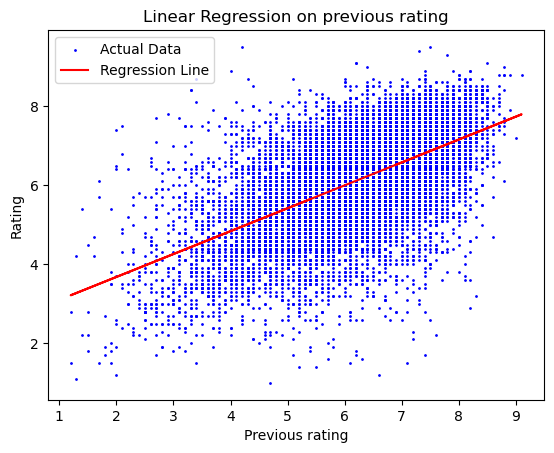

In [29]:
df = sliding_windows(ratings_sequence_df, 2)
X = df[:, :-1] 
y = df[:, -1]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

plt.scatter(X, y, color='blue', label='Actual Data', s=1)
plt.plot(X, y_pred, color='red', label='Regression Line')
plt.xlabel('Previous rating')
plt.ylabel('Rating')
plt.title('Linear Regression on previous rating')
plt.legend()
plt.show()

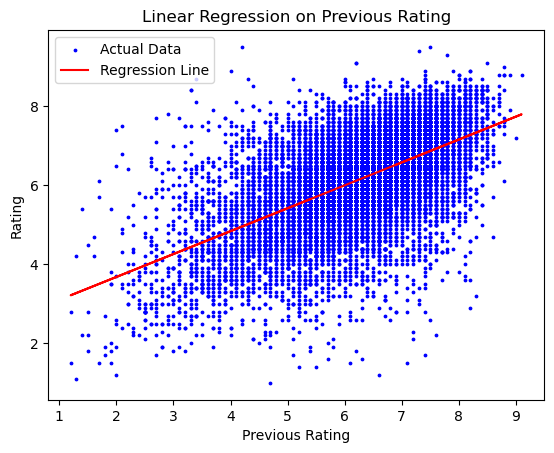

In [30]:
idx = np.random.choice(len(X), size=16000, replace=False)

plt.scatter(X[idx], y[idx], color='blue', label='Actual Data', s=3)
plt.plot(X, y_pred, color='red', label='Regression Line')
plt.xlabel('Previous Rating')
plt.ylabel('Rating')
plt.title('Linear Regression on Previous Rating')
plt.legend()
plt.show()

## See how well simply guessing the sample mean scores. 

In [31]:
E_x = directors_ratings_df["averageRating"].mean()
diffs = []
for x in X:
    d = abs(x - E_x)
    diffs.append(d)
print(f"Guessing mean MAE: {np.mean(diffs)}")


Guessing mean MAE: 1.057378422450918


In [32]:
diffs = []
for x in X:
    d = (x - E_x)**2
    diffs.append(d)
print(f"Guessing mean MSE: {np.mean(diffs)}")

Guessing mean MSE: 2.0015022693703757


## Create plots for average ratings.

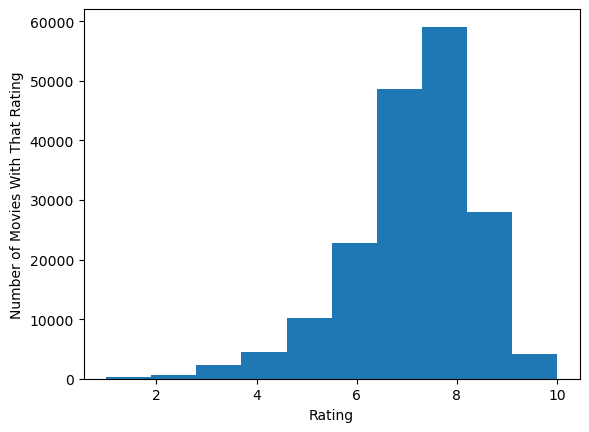

In [34]:
# Average Ratings.

plt.hist(directors_ratings_df["averageRating"])
plt.xlabel("Rating")
plt.ylabel("Number of Movies With That Rating")
plt.show()

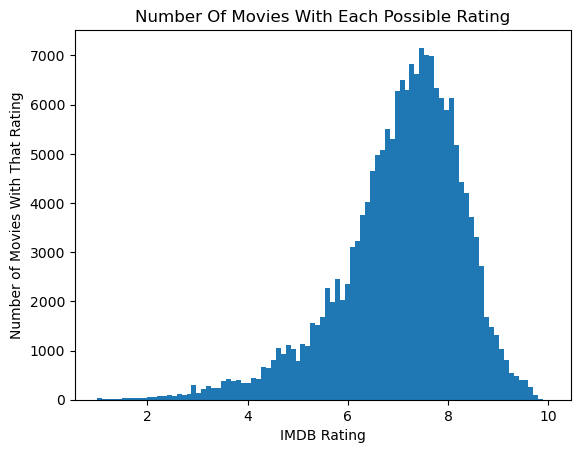

In [41]:
plt.hist(directors_ratings_df["averageRating"], bins=len(directors_ratings_df["averageRating"].unique()))
plt.title("Number Of Movies With Each Possible Rating")
plt.xlabel("IMDB Rating")
plt.ylabel("Number of Movies With That Rating")
plt.show()